In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PowerTransformer

In [2]:
url = 'DATA_Customer-Churn.csv'
df = pd.read_csv(url)

# Lab | Classification, Handling Imbalanced Data

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [4]:
def null_check(data_frame):
    print(f'Total null values per row: \n{data_frame.isnull().sum(axis=1)}\n')
    print(f'Total null values per column: \n{data_frame.isnull().sum()}\n')

In [5]:
null_check(df)

Total null values per row: 
0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Length: 7043, dtype: int64

Total null values per column: 
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64



In [6]:
# For rows with NaN in TotalCharges, calculate or replace based on the strategy

df.loc[(df['TotalCharges'].isna()) & (df['tenure'] > 1), 'TotalCharges'] = df['MonthlyCharges'] * df['tenure']
df.loc[(df['TotalCharges'].isna()) & (df['tenure'] <= 1), 'TotalCharges'] = df['MonthlyCharges']

In [7]:
df.loc[df['Churn'] == 'Yes', 'churn'] = 1
df.loc[df['Churn'] == 'No', 'churn'] = 0

In [8]:
df_filtered = df[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'churn']]

## Split Data

In [9]:
y = df_filtered['churn']  
X = df_filtered.drop(columns=['churn']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

print(X.shape)
print(y.shape)

# If 'y' is categorical and you want to see the unique classes
unique_classes = np.unique(y)
print(unique_classes)

(7043, 4)
(7043,)
[0. 1.]


## Scaling

In [10]:
#PowerTransform X_train
pt1 = PowerTransformer()
X_train = pt1.fit_transform(X_train)
#PowerTransform X_test
X_test = pt1.transform(X_test)

In [11]:
category_0 = df_filtered[df_filtered['churn'] == 0] # negative class (majority)
category_1 = df_filtered[df_filtered['churn'] == 1] # positive class (minority)

In [12]:
print(category_0.shape)
print(category_1.shape)

(5174, 5)
(1869, 5)


## Upsampling using SMOTE

In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [14]:
y_test.value_counts()

churn
0.0    1031
1.0     378
Name: count, dtype: int64

In [15]:
X_sm, y_sm = smote.fit_resample(X_train, y_train)
y_sm.value_counts()

churn
0.0    4143
1.0    4143
Name: count, dtype: int64

In [16]:
y_test.value_counts()

churn
0.0    1031
1.0     378
Name: count, dtype: int64

## Models Comparison (3 classification estimators)

In [17]:
model1 = DecisionTreeClassifier()
model2 = LogisticRegression()
model3 = KNeighborsClassifier()

model_pipeline = [model1, model2, model3]
model_names = ['Classification Tree', 'Logistic Regression', 'KNN']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_sm, y_sm, cv=5, scoring='recall'))
    scores[model_names[i]] = mean_score
    i = i+1
print(scores)

{'Classification Tree': 0.7745584284657028, 'Logistic Regression': 0.7376257990827666, 'KNN': 0.8421417457736752}


In [18]:
print("Comparing the 3 regression scores we find \n")

pd.DataFrame([scores], index=["score"])

Comparing the 3 regression scores we find 



,Classification Tree,Logistic Regression,KNN
score,0.774558,0.737626,0.842142


# KNN

In [20]:
model = KNeighborsClassifier(n_neighbors=5, weights='uniform') # declare we're using knn classification model
model.fit(X_sm, y_sm) # train model
y_pred = model.predict(X_test) # predict test, removed .values
y_pred_train = model.predict(X_sm) # predict train (for sanity checks), removed .values

performance_log = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                                'Train': [accuracy_score(y_sm, y_pred_train),
                                          precision_score(y_sm, y_pred_train),
                                          recall_score(y_sm, y_pred_train)],
                                'Test': [accuracy_score(y_test, y_pred),
                                         precision_score(y_test, y_pred),
                                         recall_score(y_test, y_pred)]})

display(performance_log)


,Error_metric,Train,Test
0,Accuracy,0.853729,0.721079
1,Precision,0.821734,0.485769
2,Recall,0.903452,0.677249


In [21]:
accuracy_score(y_sm, y_pred_train)

0.8537291817523533

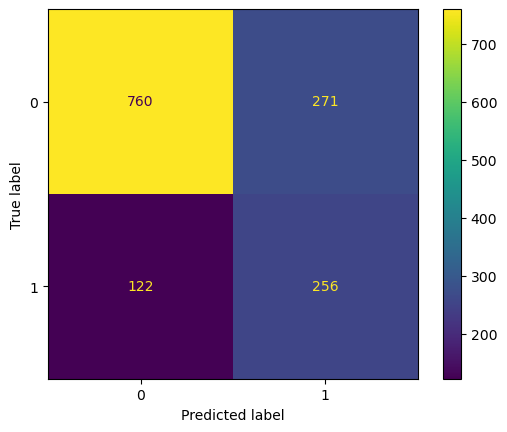

In [22]:
cm = confusion_matrix(y_test, y_pred, labels= model.classes_)
disp = ConfusionMatrixDisplay(cm)
disp.plot()